# Campus recruitment

Link to the dataset: https://www.kaggle.com/benroshan/factors-affecting-campus-placement <br>
Sorry for my English please /\

## Data

__Features list__ (`Variable`: Definition):

- `sl_no`: Serial Number
- `gender`: Gender - Male='M',Female='F'
- `ssc_p`: Secondary Education percentage - 10th Grade
- `ssc_b`: Board of Education - Central/ Others
- `hsc_p`: Higher Secondary Education percentage - 12th Grade
- `hsc_b`: Board of Education - Central/Others
- `hsc_s`: Specialization in Higher Secondary Education
- `degree_p`: Degree Percentage
- `degree_t`: Under Graduation (Degree type) - Field of degree education
- `workex`: Work Experience
- `etest_p`: Employability test percentage (conducted by college)
- `specialisation`: Post Graduation (MBA) - Specialization
- `mba_p`: MBA percentage
- `status`: Status of placement - Placed/Not placed
- `salary`: Salary offered by corporate to candidates

__Questions:__<br>
1. Which factor influenced a candidate in getting placed?
2. Does percentage matters for one to get placed?
3. Which degree specialization is much demanded by corporate?
4. Play with the data conducting all statistical tests.

__Placement_Data_Full_Class.csv__ - the dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
from scipy import stats
from statsmodels.stats.proportion import proportion_confint, proportions_ztest
from statsmodels.stats.weightstats import zconfint
import pandas as pd

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()

import statsmodels.formula.api as smf

## First look

In [2]:
data = pd.read_csv('Placement_Data_Full_Class.csv')
data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


There are some na-values in `salary` column but salary is specified only for placed people so it's useless for answering __questions__.

In [4]:
np.all((data.status == 'Not Placed') == data.salary.isna())

True

As well as `sl_no` column, it doesn't provide any useful information:

In [5]:
np.all(data.sl_no == np.arange(1, 216))

True

Dropping these columns and moving on:

In [6]:
data.drop(['sl_no', 'salary'], axis=1, inplace=True)

## Visualizations

Let's divide our features by type (binary, categorical and numerical) and plot their distributions and distributions of `status` for all of them:

In [7]:
bin_features = ['gender', 'ssc_b', 'hsc_b', 'workex', 'specialisation']
cat_features = ['hsc_s', 'degree_t']
num_features = ['ssc_p', 'hsc_p', 'degree_p', 'etest_p', 'mba_p']

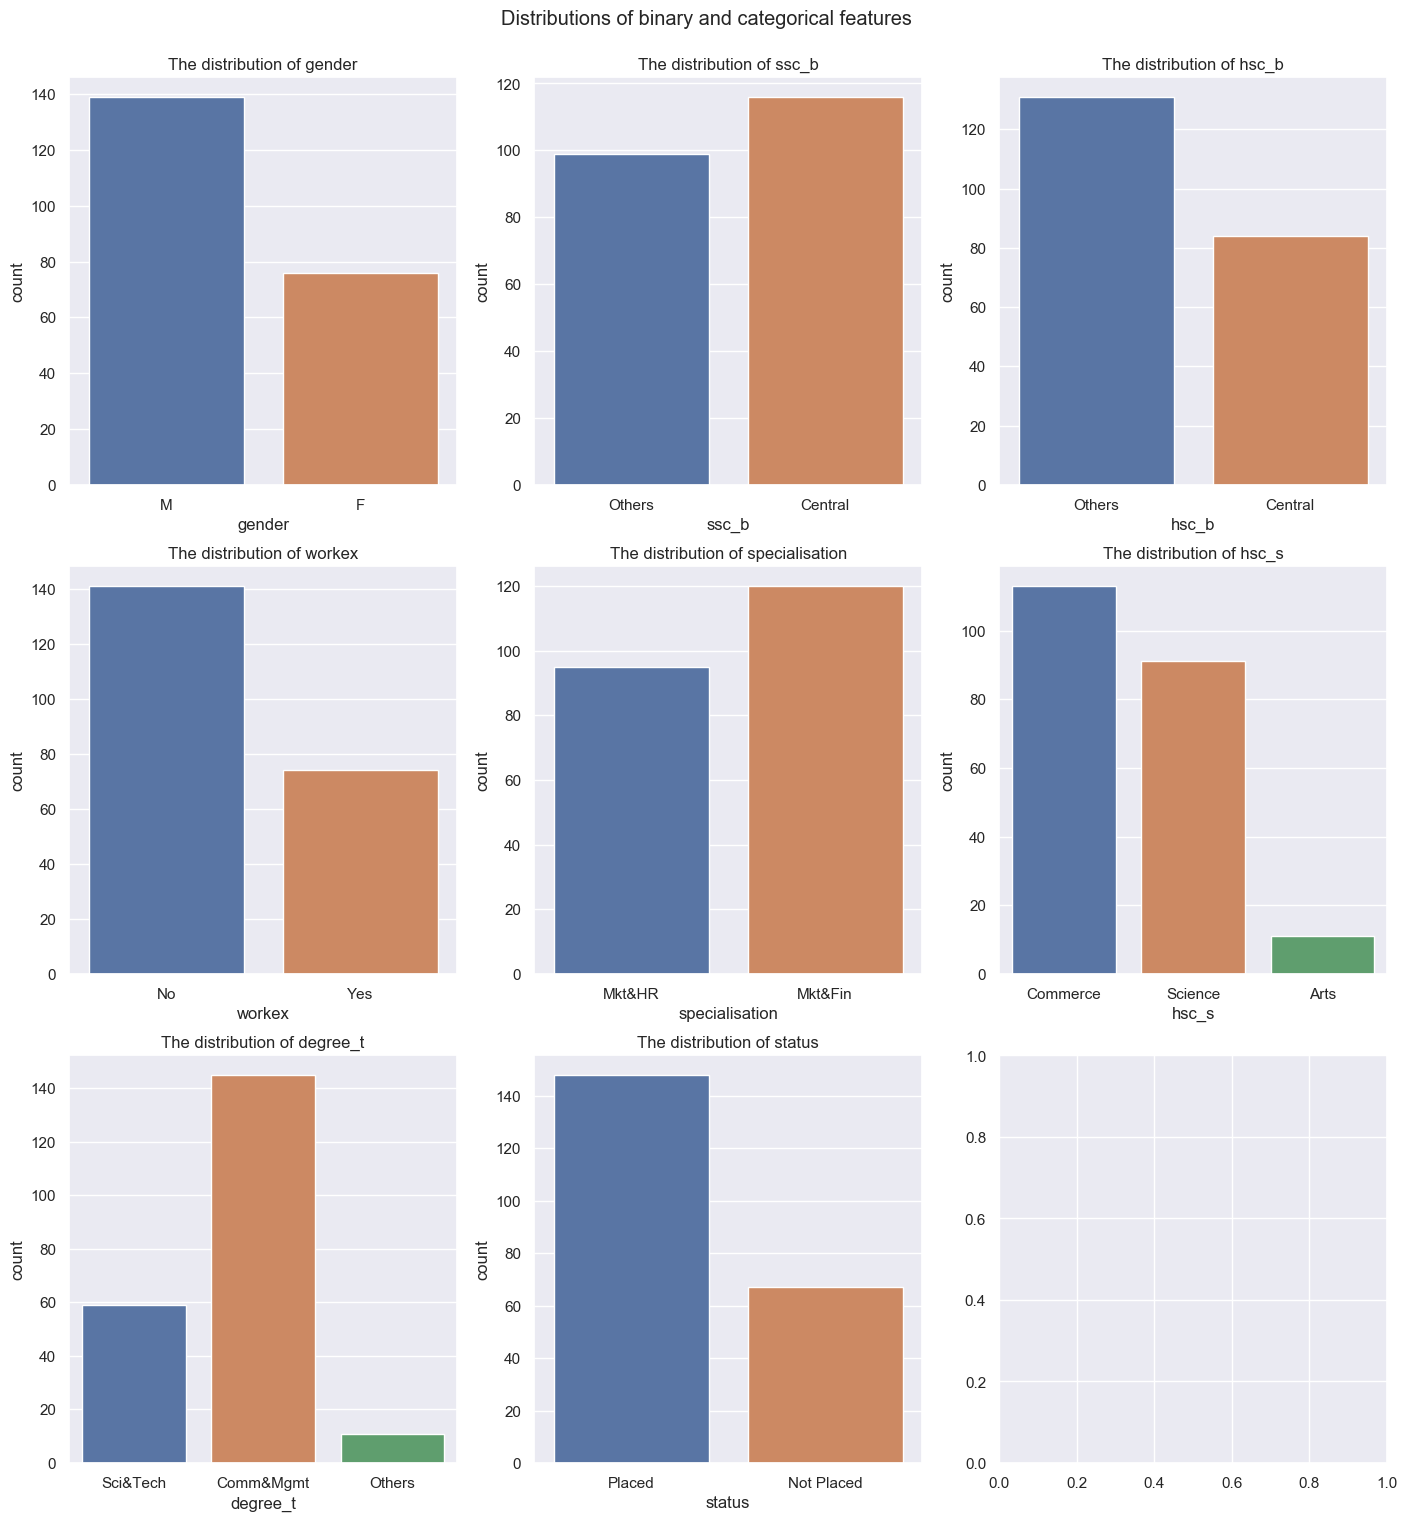

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(17, 17))

feature_names = iter(bin_features + cat_features + ['status'])
for row in range(3):
    for col in range(3):
        try:
            feature_name = next(feature_names)
        except StopIteration:
            break
        
        sns.countplot(data[feature_name], ax=axes[row, col])
        axes[row, col].set_title(f'The distribution of {feature_name}')

fig.suptitle('Distributions of binary and categorical features')
fig.subplots_adjust(top=0.94)
fig.show()

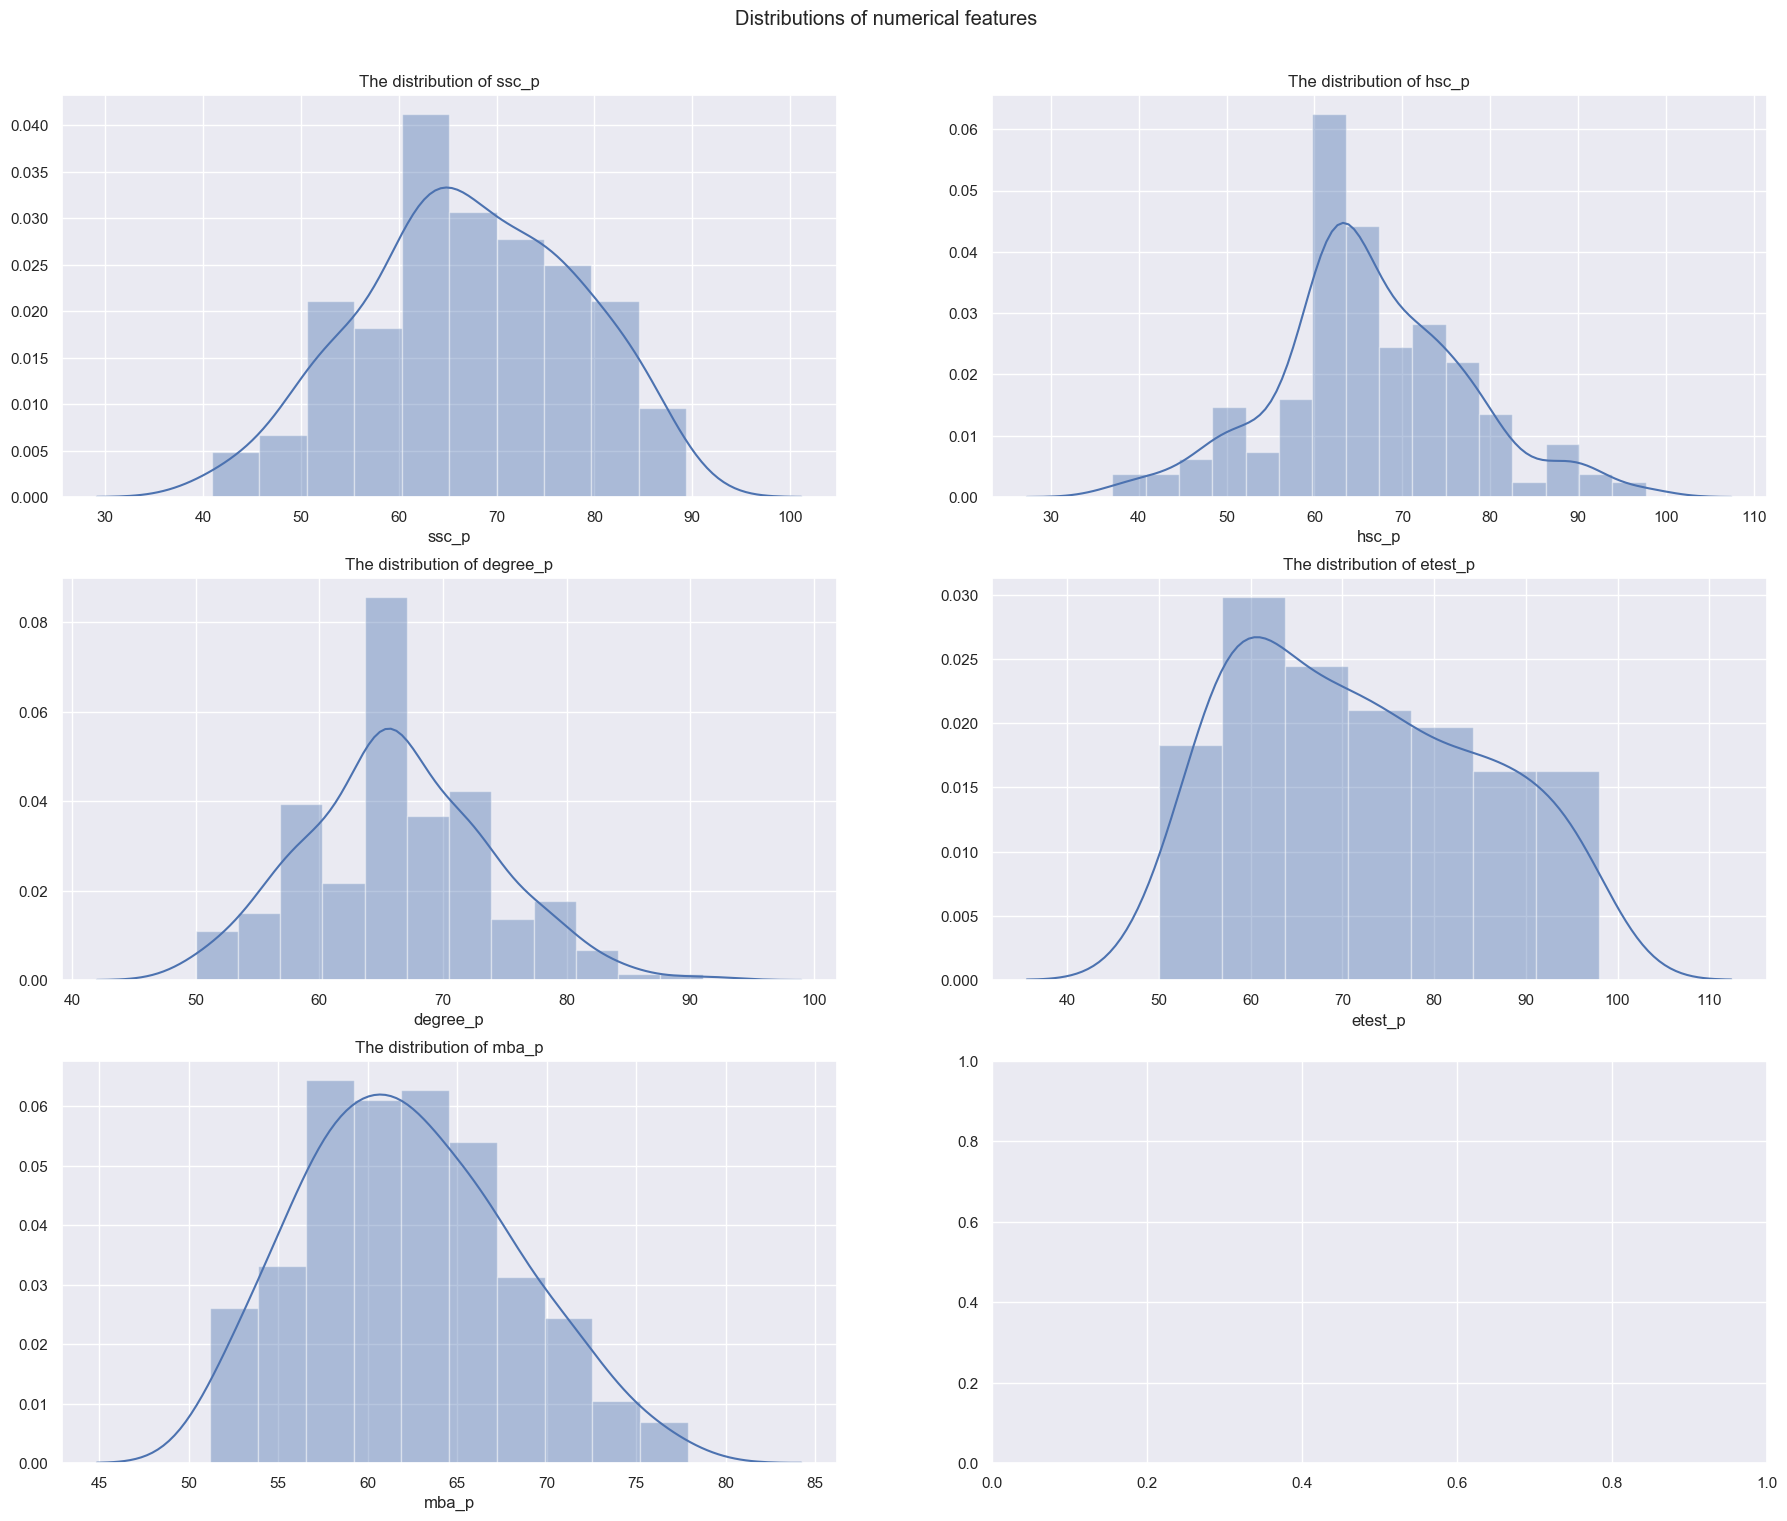

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(22, 17))

feature_names = iter(num_features)
for row in range(3):
    for col in range(2):
        try:
            feature_name = next(feature_names)
        except StopIteration:
            break
        
        sns.distplot(data[feature_name], ax=axes[row, col])    
        axes[row, col].set_title(f'The distribution of {feature_name}')
        

fig.suptitle('Distributions of numerical features')
fig.subplots_adjust(top=0.93)
fig.show()

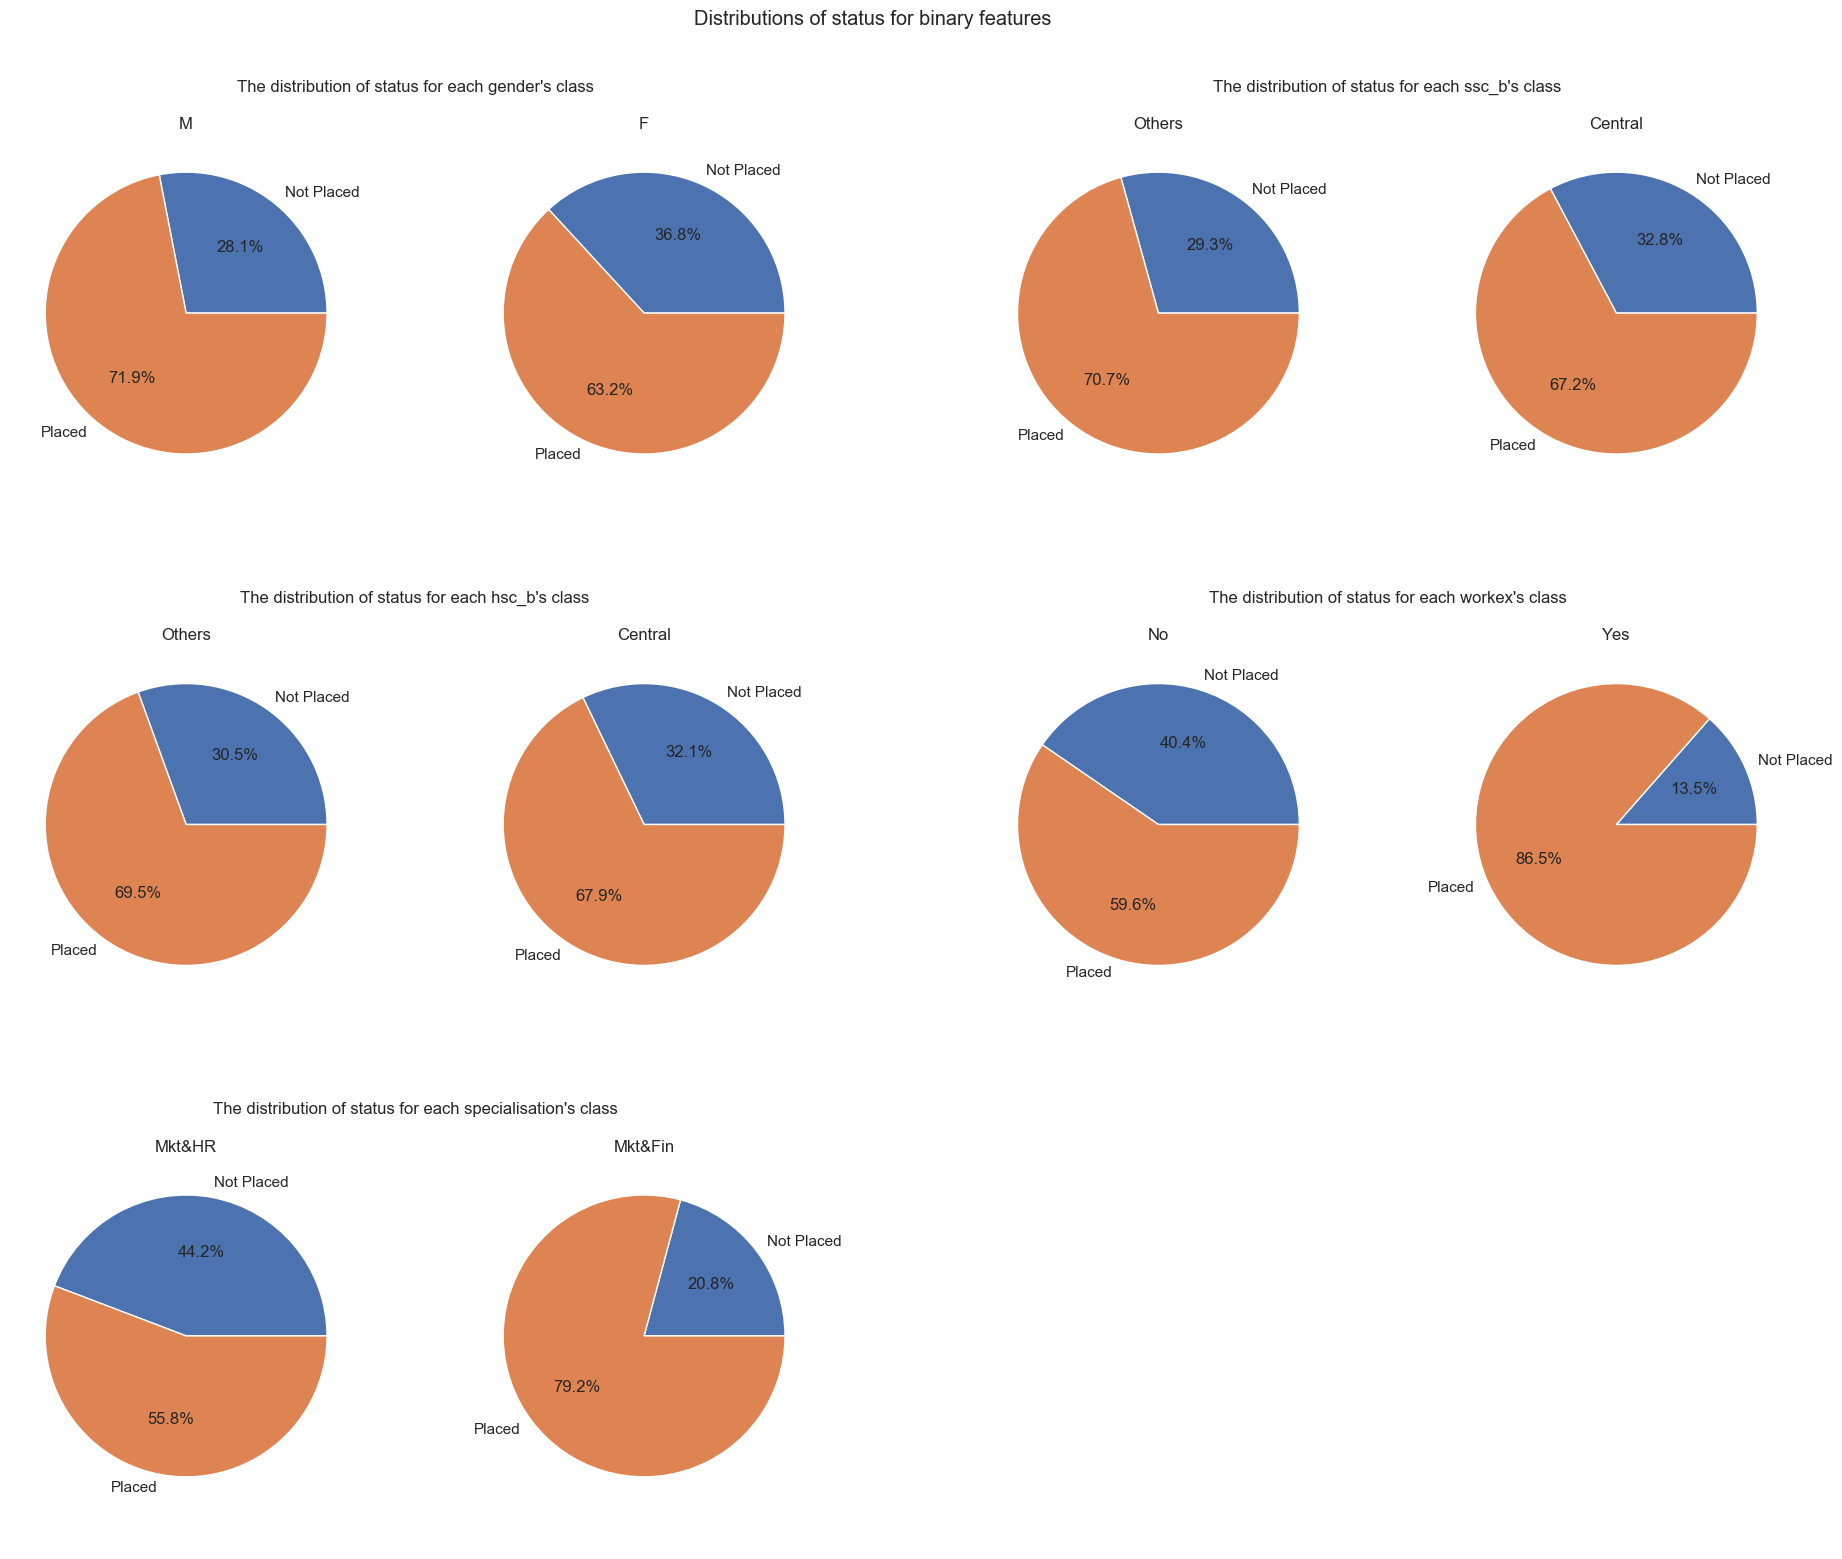

In [10]:
fig = plt.figure(figsize=(23, 18))
outer = gridspec.GridSpec(3, 2, wspace=0.2, hspace=0.2)

for feature_ind, feature_name in enumerate(bin_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[feature_ind], 
                                             wspace=0.3, hspace=0.3)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'The distribution of status for each {feature_name}\'s class')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for pie_ind, f_class in enumerate(data[feature_name].unique()):
        ax = plt.Subplot(fig, inner[pie_ind])
        f_class_status_vc = data[data[feature_name] == f_class]['status'].value_counts().sort_index()
        ax.pie(f_class_status_vc.values, labels=f_class_status_vc.index, autopct='%1.1f%%')
        ax.set_title(f_class)
        fig.add_subplot(ax)

fig.suptitle('Distributions of status for binary features')
fig.subplots_adjust(top=0.93)
fig.show()

__Question 3.__ (Which degree specialization is much demanded by corporate?) Look's like that Mkt&Fin is.

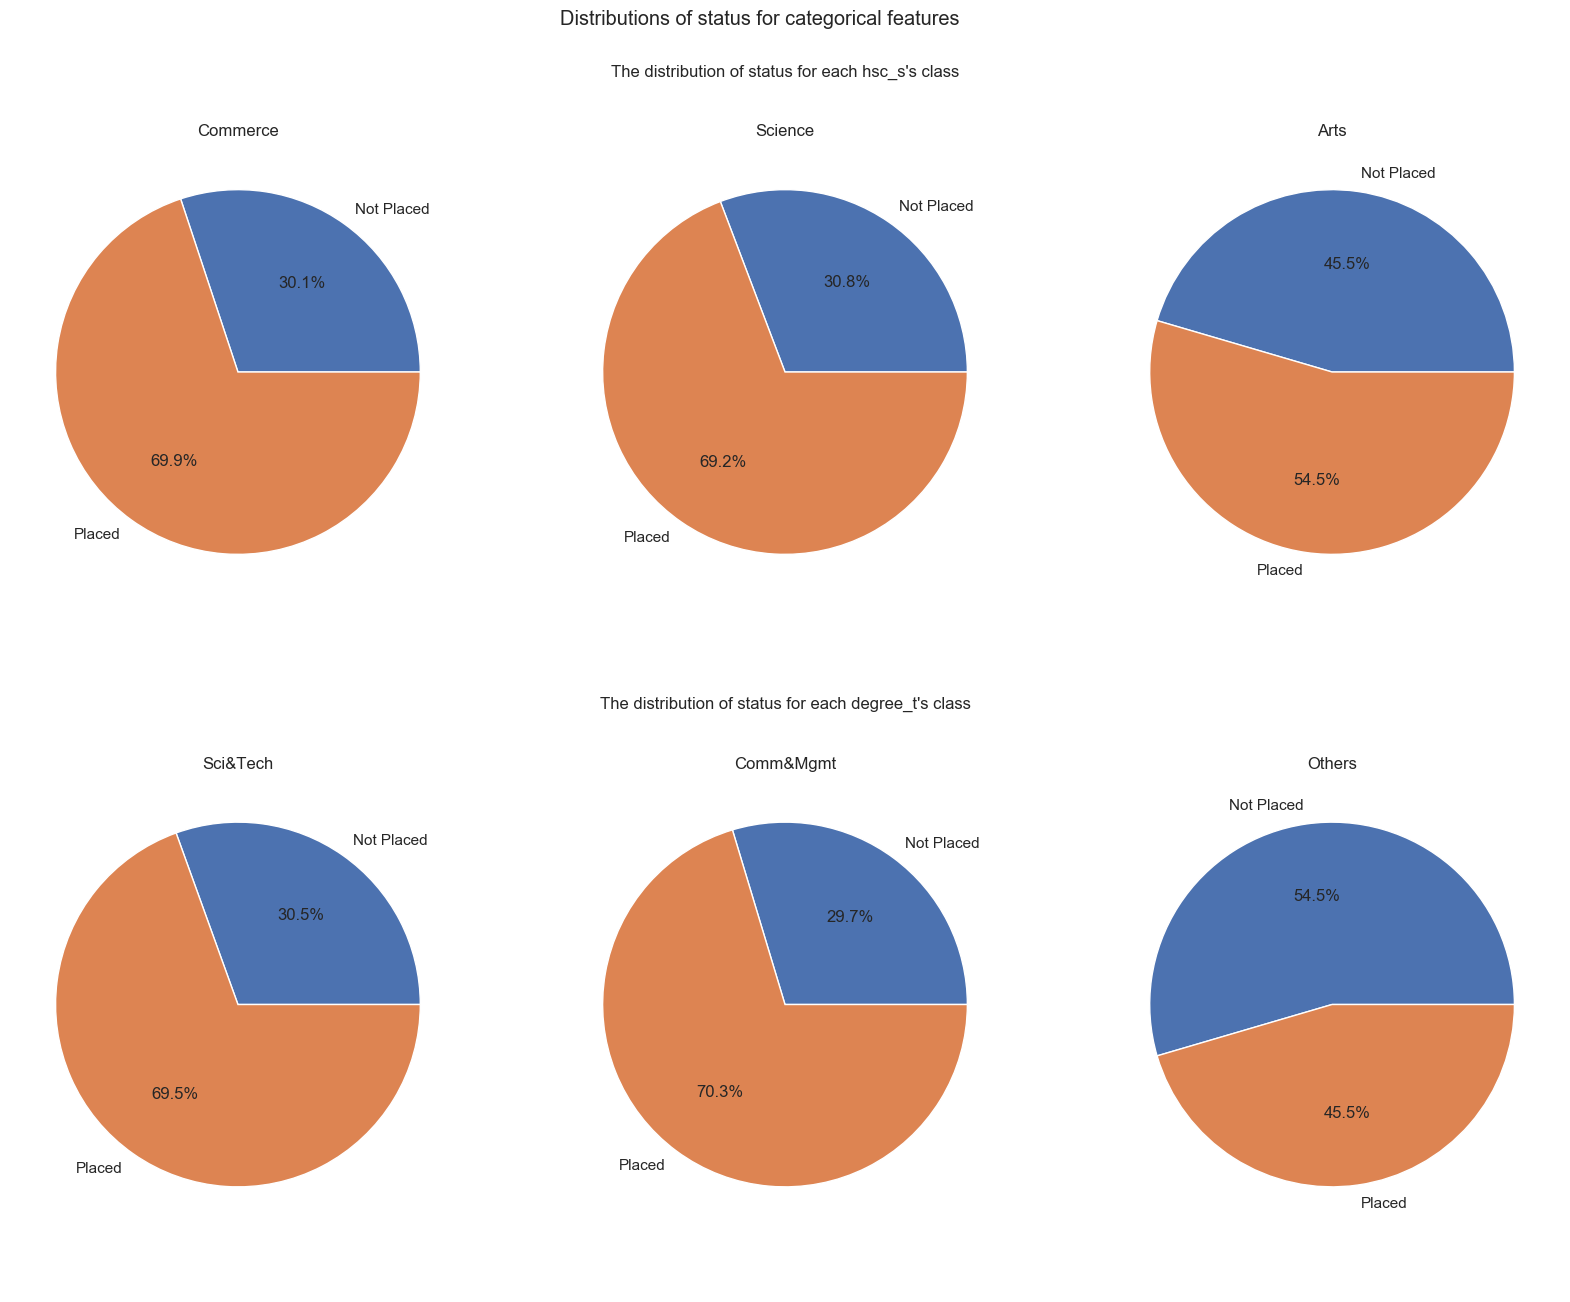

In [11]:
fig = plt.figure(figsize=(20, 15))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.1)

for feature_ind, feature_name in enumerate(cat_features):
    inner = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[feature_ind], 
                                             wspace=0.2, hspace=0.2)
    
    ax = plt.Subplot(fig, outer[feature_ind])
    ax.set_title(f'The distribution of status for each {feature_name}\'s class')
    ax.axis('off')
    fig.add_subplot(ax)
    
    for pie_ind, f_class in enumerate(data[feature_name].unique()):
        ax = plt.Subplot(fig, inner[pie_ind])
        f_class_status_vc = data[data[feature_name] == f_class]['status'].value_counts().sort_index()
        ax.pie(f_class_status_vc.values, labels=f_class_status_vc.index, autopct='%1.1f%%')
        ax.set_title(f_class)
        fig.add_subplot(ax)

fig.suptitle('Distributions of status for categorical features')
fig.subplots_adjust(top=0.93)
fig.show()

In [12]:
# transforming status into binary feature to calculate proportions
data_01_status = data.copy()
data_01_status['status'].replace({'Placed': 1, 'Not Placed': 0}, inplace=True)

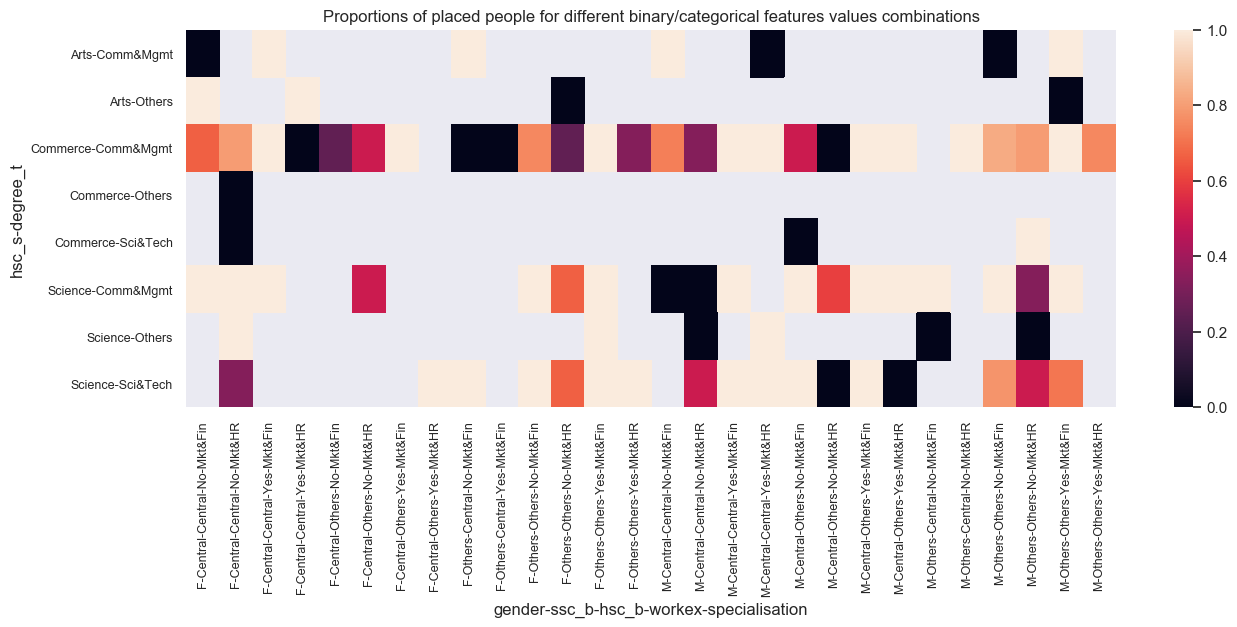

In [13]:
plt.figure(figsize=(15, 5))
sns.heatmap(pd.pivot_table(data_01_status, index=cat_features, columns=bin_features, 
                           values='status', aggfunc=np.mean)).tick_params(labelsize=9)
plt.title('Proportions of placed people for different binary/categorical features values combinations')
plt.show()

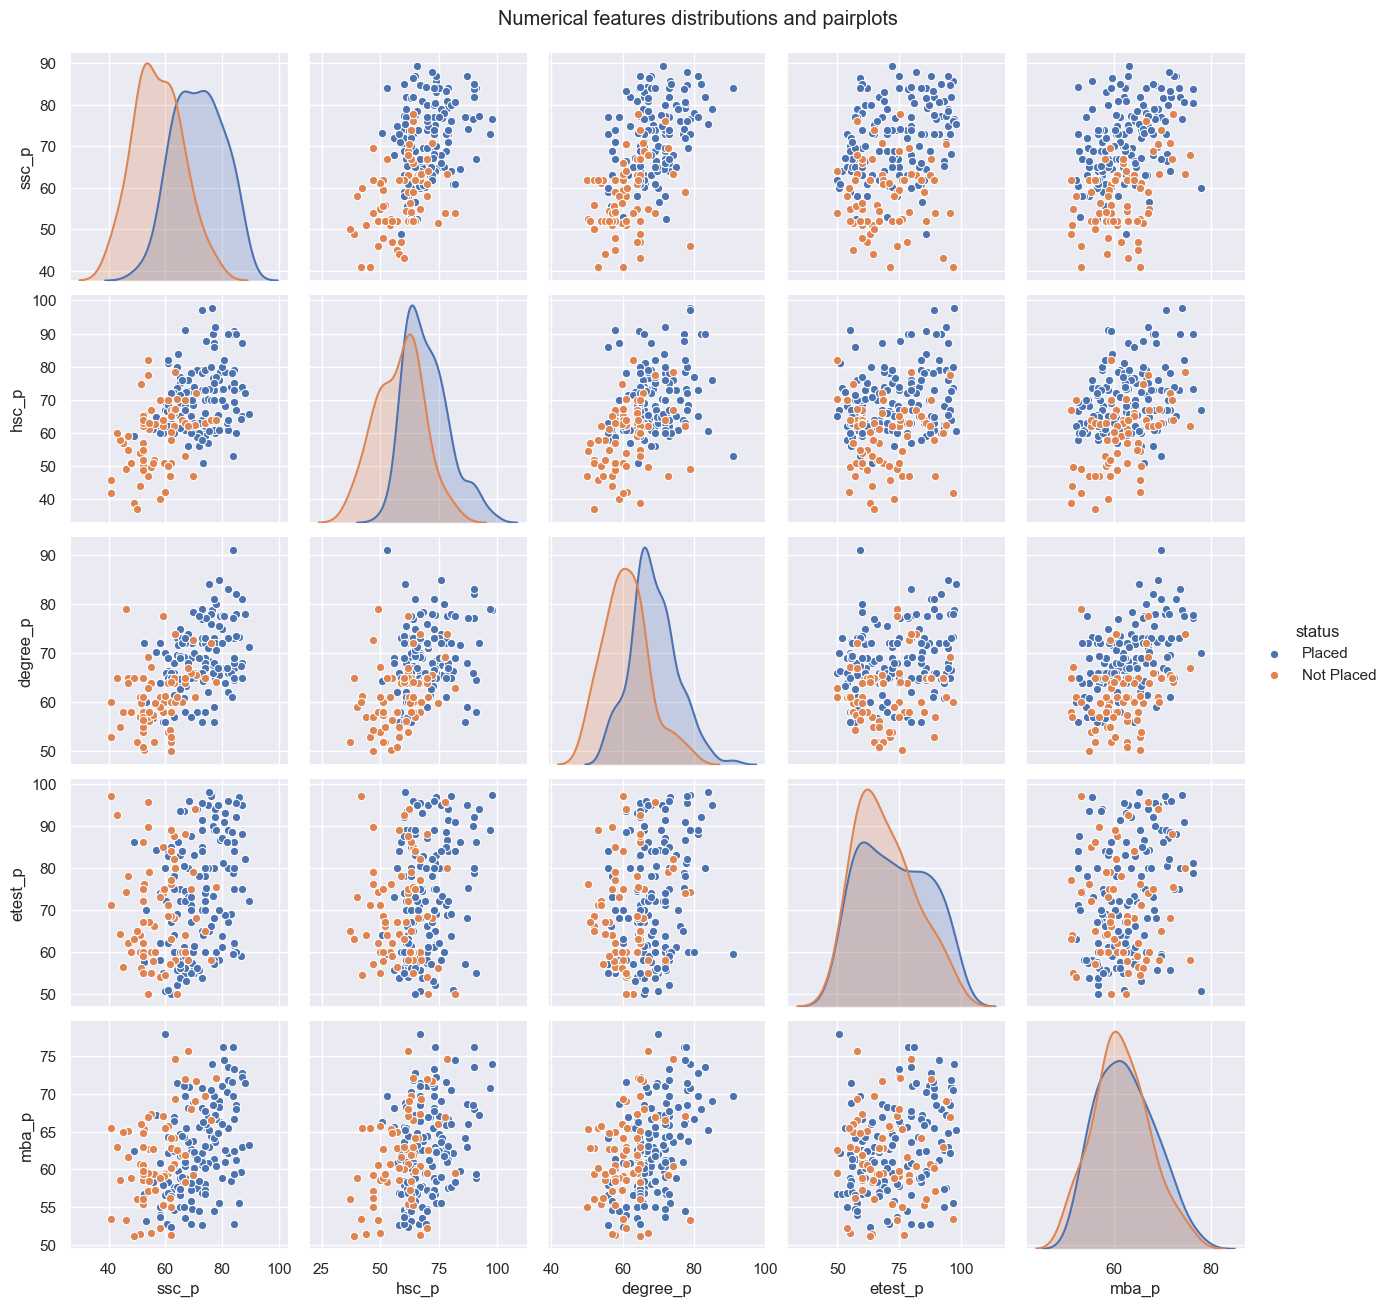

In [14]:
pp = sns.pairplot(data[num_features + ['status']], hue='status')
pp.fig.suptitle('Numerical features distributions and pairplots', y=1.03)
pp.fig.show()

__Question 2.__ (Does percentage matters for one to get placed?) Look's like `ssc_p`, `hsc_p` and `degree_p` matter.

## Statistics

(__Question 4.__)

In [15]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    '''Confidence interval for the difference in two independent proportions.'''    
    z = stats.norm.ppf(1 - alpha / 2)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return left_boundary, right_boundary

In [16]:
print('BINARY FEATURES\n===============\n\n')
for feature_name in bin_features:
    class1, class2 = data_01_status[feature_name].unique()
    class1_status = data_01_status[data[feature_name] == class1].status
    class2_status = data_01_status[data[feature_name] == class2].status
    
    class1_status_count, class1_status_nobs = sum(class1_status), len(class1_status)
    class2_status_count, class2_status_nobs = sum(class2_status), len(class2_status)
    
    print(f'Feature: {feature_name}\n------')
    
    print(f'Proportion of placed people for {class1}: {round(class1_status_count / class1_status_nobs, 4)}')
    print(f'Proportion of placed people for {class2}: {round(class2_status_count / class2_status_nobs, 4)}')
    
    class1_confint = list(map(lambda lim: round(lim, 4), proportion_confint(class1_status_count, 
                                                                            class1_status_nobs, 
                                                                            method='wilson')))
    class2_confint = list(map(lambda lim: round(lim, 4), proportion_confint(class2_status_count, 
                                                                            class2_status_nobs, 
                                                                            method='wilson')))
    print(f'Сonfidence interval (95%) for {class1}: {class1_confint}')
    print(f'Сonfidence interval (95%) for {class2}: {class2_confint}')
    
    prop_diff_confint = list(map(lambda lim: round(lim, 4), proportions_diff_confint_ind(class1_status, 
                                                                                         class2_status)))
    print(f'Confidence interval (95%) for the difference in proportions: {prop_diff_confint}')
    
    stat, p = proportions_ztest([class1_status_count, class2_status_count], 
                                [class1_status_nobs, class2_status_nobs])
    print(f'Z-test of {feature_name} proportions (two-sided): {p} (p-value)')
    print('\n\n')

BINARY FEATURES


Feature: gender
------
Proportion of placed people for M: 0.7194
Proportion of placed people for F: 0.6316
Сonfidence interval (95%) for M: [0.6396, 0.7874]
Сonfidence interval (95%) for F: [0.5193, 0.7312]
Confidence interval (95%) for the difference in proportions: [-0.0438, 0.2195]
Z-test of gender proportions (two-sided): 0.1836866900162275 (p-value)



Feature: ssc_b
------
Proportion of placed people for Others: 0.7071
Proportion of placed people for Central: 0.6724
Сonfidence interval (95%) for Others: [0.611, 0.7876]
Сonfidence interval (95%) for Central: [0.5827, 0.7511]
Confidence interval (95%) for the difference in proportions: [-0.0892, 0.1585]
Z-test of ssc_b proportions (two-sided): 0.5844651480115949 (p-value)



Feature: hsc_b
------
Proportion of placed people for Others: 0.6947
Proportion of placed people for Central: 0.6786
Сonfidence interval (95%) for Others: [0.6112, 0.767]
Сonfidence interval (95%) for Central: [0.5728, 0.7687]
Confidence inter

The differences in proportions of placed people for `workex` and `specialization` (__Question 3.__ Which degree specialization is much demanded by corporate?) classes are statistically significant (__p-value__ < 0.05 and < 0.01), differences in all the rest ones - aren't.

In [17]:
for feature_name in cat_features:
    feature_0s_vc = data_01_status[data_01_status.status == 0][feature_name].value_counts()
    feature_1s_vc = data_01_status[data_01_status.status == 1][feature_name].value_counts()
    
    feature_status_info = pd.DataFrame({'s0': feature_0s_vc, 
                                        's1': feature_1s_vc})
    feature_status_info['total'] = feature_status_info['s0'] + feature_status_info['s1']
    feature_status_info['prop_of_1'] = feature_status_info['s1'] / feature_status_info['total']
    
    prop_1_mean = feature_status_info['prop_of_1'].mean()
    expected_for_1 = round(feature_status_info['total'] * prop_1_mean)
    
    stat, p = stats.chisquare(feature_status_info['s1'], expected_for_1, ddof=1)
    print(f'Chi-square test of {feature_name}\'s classes proportions of placed people: {p} (p-value)')

Chi-square test of hsc_s's classes proportions of placed people: 0.34085995945770664 (p-value)
Chi-square test of degree_t's classes proportions of placed people: 0.09047660597345085 (p-value)


Proportions of placed people in every categorical feature for each class seem to be distributed uniformly.

In [18]:
print('NUMERICAL FEATURES\n==================\n\n')
for feature_name in num_features:
    feature_0s = data_01_status[data_01_status.status == 0][feature_name]
    feature_1s = data_01_status[data_01_status.status == 1][feature_name]
    
    print(f'Feature: {feature_name}\n------')
    print(f'Mean of {feature_name} for placed people:     {round(feature_1s.mean(), 4)}')
    print(f'Mean of {feature_name} for not placed people: {round(feature_0s.mean(), 4)}')
    
    feature_0s_confint = list(map(lambda lim: round(lim, 4), zconfint(zconfint(feature_0s.values))))
    feature_1s_confint = list(map(lambda lim: round(lim, 4), zconfint(zconfint(feature_1s.values))))
    
    print(f'Confidence interval (95%) of mean {feature_name} for placed people:     {feature_1s_confint}')
    print(f'Confidence interval (95%) of mean {feature_name} for not placed people: {feature_0s_confint}')

    stat, p = stats.kruskal(feature_0s, feature_1s)
    print(f'Kruskal-Wallis H Test result: {p} (p-value)')
    print('\n\n')

NUMERICAL FEATURES


Feature: ssc_p
------
Mean of ssc_p for placed people:     71.7215
Mean of ssc_p for not placed people: 57.544
Confidence interval (95%) of mean ssc_p for placed people:     [68.9694, 74.4735]
Confidence interval (95%) of mean ssc_p for not placed people: [53.6045, 61.4835]
Kruskal-Wallis H Test result: 1.6751463798396454e-18 (p-value)



Feature: hsc_p
------
Mean of hsc_p for placed people:     69.9266
Mean of hsc_p for not placed people: 58.3955
Confidence interval (95%) of mean hsc_p for placed people:     [66.9807, 72.8724]
Confidence interval (95%) of mean hsc_p for not placed people: [53.7428, 63.0483]
Kruskal-Wallis H Test result: 1.1865333364186911e-11 (p-value)



Feature: degree_p
------
Mean of degree_p for placed people:     68.7405
Mean of degree_p for not placed people: 61.1342
Confidence interval (95%) of mean degree_p for placed people:     [66.6824, 70.7987]
Confidence interval (95%) of mean degree_p for not placed people: [58.1466, 64.1217]
Krusk

__Question 2.__ (Does percentage matters for one to get placed?) Differences in means of `ssc_p`, `hsc_p` and `degree_p` for placed and not placed people are statistically significant (__p-value__ < 0.05 and < 0.01), differences in all the rest ones - aren't.

## Logistic regression model

Let's train a Logisctic regression model and look at it's weights. But firstly transform percents to proportions:

In [19]:
for perc_feature_name in num_features:
    data_01_status[perc_feature_name] = data_01_status[perc_feature_name] / 100

data_01_status[num_features].describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,215.000000,215.000000,215.000000,215.000000,215.000000
mean,0.673034,0.663332,0.663702,0.721006,0.622782
std,0.108272,0.108975,0.073587,0.132760,0.058334
min,0.408900,0.370000,0.500000,0.500000,0.512100
25%,0.606000,0.609000,0.610000,0.600000,0.579450
50%,0.670000,0.650000,0.660000,0.710000,0.620000
75%,0.757000,0.730000,0.720000,0.835000,0.662550
max,0.894000,0.977000,0.910000,0.980000,0.778900


In [20]:
data_01_status.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,M,0.6700,Others,0.9100,Others,Commerce,0.5800,Sci&Tech,No,0.550,Mkt&HR,0.5880,1
1,M,0.7933,Central,0.7833,Others,Science,0.7748,Sci&Tech,Yes,0.865,Mkt&Fin,0.6628,1
2,M,0.6500,Central,0.6800,Central,Arts,0.6400,Comm&Mgmt,No,0.750,Mkt&Fin,0.5780,1
3,M,0.5600,Central,0.5200,Central,Science,0.5200,Sci&Tech,No,0.660,Mkt&HR,0.5943,0
4,M,0.8580,Central,0.7360,Central,Commerce,0.7330,Comm&Mgmt,No,0.968,Mkt&Fin,0.5550,1


Fitting model and printing statistics:

In [21]:
formula = 'status ~ C(' + ') + C('.join(bin_features + cat_features) + ') + ' + ' + '.join(num_features)
formula

'status ~ C(gender) + C(ssc_b) + C(hsc_b) + C(workex) + C(specialisation) + C(hsc_s) + C(degree_t) + ssc_p + hsc_p + degree_p + etest_p + mba_p'

In [22]:
model1 = smf.logit(formula, data=data_01_status)
fitted1 = model1.fit()
print(fitted1.summary())

Optimization terminated successfully.
         Current function value: 0.231806
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                  215
Model:                          Logit   Df Residuals:                      200
Method:                           MLE   Df Model:                           14
Date:                Sat, 16 May 2020   Pseudo R-squ.:                  0.6264
Time:                        17:58:28   Log-Likelihood:                -49.838
converged:                       True   LL-Null:                       -133.39
Covariance Type:            nonrobust   LLR p-value:                 2.643e-28
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -18.3717      5.324     -3.451      0.001   

__p-value__ < 0.05 for `degree_t`, `workex`, `ssc_p`, `hsc_p`, `degree_p` and `mba` weights. Look's like other features aren't important for `status` prediction (if Logistic regression is used). Let's fit another model using only them:

In [23]:
formula = 'status ~ C(degree_t) + C(workex) + ssc_p + hsc_p + degree_p + mba_p'

In [24]:
model2 = smf.logit(formula, data=data_01_status)
fitted2 = model2.fit()
print(fitted2.summary())

Optimization terminated successfully.
         Current function value: 0.251513
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                  215
Model:                          Logit   Df Residuals:                      207
Method:                           MLE   Df Model:                            7
Date:                Sat, 16 May 2020   Pseudo R-squ.:                  0.5946
Time:                        17:58:30   Log-Likelihood:                -54.075
converged:                       True   LL-Null:                       -133.39
Covariance Type:            nonrobust   LLR p-value:                 6.259e-31
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 -15.7115      3.968     -3.960      0.000     -23.489   

Seems it hasn't become much worse. 

Depending on model's info we can conclude:

- __Question 1.__ (Which factor influenced a candidate in getting placed?) `degree_t` (doubtful) and `workex` are.<br>
- __Question 2.__ (Does percentage matters for one to get placed?) Yes, `ssc_p`, `hsc_p`, `degree_p` and `mba_p` matter.